In [34]:
!pip install tensorflow==2.11.0

  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [1]:
!pip install tensorflow_datasets

  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [1]:
!sudo apt install curl gnupg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gnupg is already the newest version (2.2.27-3ubuntu2.1).
The following additional packages will be installed:
  libcurl4 libcurl4-openssl-dev
Suggested packages:
  libcurl4-doc libidn11-dev libldap2-dev librtmp-dev
The following packages will be upgraded:
  curl libcurl4 libcurl4-openssl-dev
3 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Need to get 869 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4-openssl-dev amd64 7.81.0-1ubuntu1.15 [386 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.15 [194 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.15 [289 kB]
Fetched 794 kB in 1s (1,051 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program

In [2]:
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  4714  100  4714    0     0  16448      0 --:--:-- --:--:-- --:--:-- 16482
OK


In [3]:
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list

deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8


In [4]:
!sudo apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://storage.googleapis.com/bazel-apt stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
27 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://storage.googleapis.com

In [5]:
!sudo apt install bazel=5.4.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bazel is already the newest version (5.4.0).
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.


In [6]:
!git clone https://www.github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [7]:
!models/research/seq_flow_lite/demo/colab/setup_workspace.sh

mv: cannot stat 'setup.py': No such file or directory
touch: cannot touch '../../tf_ops/__init__.py': No such file or directory


In [8]:
!pip install models/research/seq_flow_lite

Processing ./models/research/seq_flow_lite
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [9]:
!rm -rf models/research/seq_flow_lite/tf_ops

In [20]:
!rm -rf models/research/seq_flow_list/tflite_ops

In [21]:
%cd models/research/seq_flow_lite

/content/models/research/seq_flow_lite


In [22]:
import tensorflow as tf

In [23]:
import tensorflow_datasets as tfds

In [24]:
ds = tfds.load('goemotions', split='train')

In [25]:
for element in ds.take(5):
  print(element)

{'admiration': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'amusement': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'anger': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'annoyance': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'approval': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'caring': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'comment_text': <tf.Tensor: shape=(), dtype=string, numpy=b"It's just wholesome content, from questionable sources">, 'confusion': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'curiosity': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'desire': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'disappointment': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'disapproval': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'disgust': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'embarrassment': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'excitement': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'fear': <tf.Tensor: shape=(

In [26]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]


In [27]:
CONFIG = {
    'name': 'models.prado',
    'batch_size': 1024,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

In [28]:
CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

In [29]:
MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 128,
    'max_seq_len_inference': 128,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

In [30]:
CONFIG['model_config'] = MODEL_CONFIG

In [24]:
!pip install layers

In [29]:
from tensorflow.keras import layers

In [76]:
from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['comment_text']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = tfds.load('goemotions', split=split)
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input,
              num_parallel_calls=tf.data.experimental.AUTOTUNE,
              deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

In [77]:
from models import prado

def build_model(mode):
  # First we define our inputs.
  inputs = []
  if mode == base_layers.TRAIN or mode == base_layers.EVAL:
    # For TRAIN and EVAL, we'll be getting dataset examples,
    # so we'll get projections and sequence_lengths.
    projection = tf.keras.Input(
        shape=(MODEL_CONFIG['max_seq_len'], MODEL_CONFIG['feature_size']),
        name='projection',
        dtype='float32')

    sequence_length = tf.keras.Input(
        shape=(), name='sequence_length', dtype='float32')
    inputs = [projection, sequence_length]
  else:
    # Otherwise, we get string inputs which we need to project.
    input = tf.keras.Input(shape=(), name='input', dtype='string')
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, sequence_length = projection_layer(input)
    inputs = [input]

  # Next we add the model layer.
  model_layer = prado.Encoder(MODEL_CONFIG, mode)
  logits = model_layer(projection, sequence_length)

  # Finally we add an activation layer.
  if MODEL_CONFIG['multilabel']:
    activation = tf.keras.layers.Activation('sigmoid', name='predictions')
  else:
    activation = tf.keras.layers.Activation('softmax', name='predictions')
  predictions = activation(logits)

  model = tf.keras.Model(
      inputs=inputs,
      outputs=[predictions])

  return model

In [78]:
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'])

model.save_weights('model/model_checkpoint')

Epoch 1/10
1000/1000 [==============================] - 261s 254ms/step - loss: 0.6071 - val_loss: 0.5232
Epoch 2/10
1000/1000 [==============================] - 259s 259ms/step - loss: 0.4891 - val_loss: 0.4684
Epoch 3/10
1000/1000 [==============================] - 254s 254ms/step - loss: 0.4565 - val_loss: 0.4499
Epoch 4/10
1000/1000 [==============================] - 255s 255ms/step - loss: 0.4452 - val_loss: 0.4444
Epoch 5/10
1000/1000 [==============================] - 256s 256ms/step - loss: 0.4413 - val_loss: 0.4428
Epoch 6/10
1000/1000 [==============================] - 255s 255ms/step - loss: 0.4400 - val_loss: 0.4423
Epoch 7/10
1000/1000 [==============================] - 256s 256ms/step - loss: 0.4395 - val_loss: 0.4407
Epoch 8/10
1000/1000 [==============================] - 255s 255ms/step - loss: 0.4392 - val_loss: 0.4408
Epoch 9/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.4392 - val_loss: 0.4411
Epoch 10/10
1000/1000 [=======================

In [79]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

model.compile(metrics=metrics)
model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)


5/5 [==============================] - 5s 289ms/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.5906 - recall@0.5/admiration: 0.5118 - precision@0.5/amusement: 0.7414 - recall@0.5/amusement: 0.6772 - precision@0.5/anger: 0.4917 - recall@0.5/anger: 0.3105 - precision@0.5/annoyance: 0.2090 - recall@0.5/annoyance: 0.0464 - precision@0.5/approval: 0.7143 - recall@0.5/approval: 0.0457 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.4286 - recall@0.5/confusion: 0.0417 - precision@0.5/curiosity: 0.3315 - recall@0.5/curiosity: 0.2239 - precision@0.5/desire: 0.5333 - recall@0.5/desire: 0.1975 - precision@0.5/disappointment: 0.5000 - recall@0.5/disappointment: 0.0071 - precision@0.5/disapproval: 0.3273 - recall@0.5/disapproval: 0.1417 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.2105 - recall@0.5/excitement: 0

In [80]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))

precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  print('all: (precision@0.5: {}, recall@0.5: {})'.format(
      result[precision_key], result[recall_key]))

admiration: (precision@0.5: 0.5905707478523254, recall@0.5: 0.5118279457092285)
amusement: (precision@0.5: 0.7413793206214905, recall@0.5: 0.6771653294563293)
anger: (precision@0.5: 0.49166667461395264, recall@0.5: 0.3105263113975525)
annoyance: (precision@0.5: 0.20895522832870483, recall@0.5: 0.046357616782188416)
approval: (precision@0.5: 0.7142857313156128, recall@0.5: 0.04573170840740204)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.4285714328289032, recall@0.5: 0.0416666679084301)
curiosity: (precision@0.5: 0.33149170875549316, recall@0.5: 0.2238806039094925)
desire: (precision@0.5: 0.5333333611488342, recall@0.5: 0.1975308656692505)
disappointment: (precision@0.5: 0.5, recall@0.5: 0.007092198356986046)
disapproval: (precision@0.5: 0.3272727131843567, recall@0.5: 0.14173229038715363)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.21052631735801697, recall@0.5: 0.0399999

In [81]:
EMOTION_MAP = {
    'admiration': 'admiration',
    'amusement': 'amusement',
    'anger': 'anger',
    'annoyance': 'annoyance',
    'approval': 'approval',
    'caring': 'caring',
    'confusion': 'confusion',
    'curiosity': 'curiosity',
    'desire': 'desire',
    'disappointment': 'disappointment',
    'disapproval': 'disapproval',
    'disgust': 'disgust',
    'embarrassment': 'embarrassment',
    'excitement': 'excitement',
    'fear': 'fear',
    'gratitude': 'gratitude',
    'grief': 'grief',
    'joy': 'joy',
    'love': 'love',
    'nervousness': 'nervousness',
    'optimism': 'optimism',
    'pride': 'pride',
    'realization': 'realization',
    'relief': 'relief',
    'remorse': 'remorse',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'neutral': 'neutral',
}

In [82]:
import pandas as pd

In [83]:
from google.colab import files

In [85]:
import io

In [86]:
yikyaks = pd.read_csv('/database.csv')

In [101]:
yikyaks.iloc[:, 0] = yikyaks.iloc[:, 0]

<ipython-input-101-f2663a923fa2>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  yikyaks.iloc[:, 0] = yikyaks.iloc[:, 0]


In [102]:
grouped_data = yikyaks.groupby(yikyaks.iloc[:, 0])

In [90]:
!pip install matplotlib

In [91]:
import matplotlib.pyplot as plt

In [92]:
from matplotlib.cm import get_cmap

In [93]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 projection (InputLayer)        [(None, 128, 512)]   0           []                               
                                                                                                  
 sequence_length (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 encoder_5 (Encoder)            (None, 28)           112140      ['projection[0][0]',             
                                                                  'sequence_length[0][0]']        
                                                                                                  
 predictions (Activation)       (None, 28)           0           ['encoder_5[0][0]']        

In [94]:
import numpy as np

In [96]:
PREDICT_TEXT = [
  b'Good for you!',
  b'Happy birthday!',
  b'I love you.',
]

In [97]:
import numpy as np

model = build_model(base_layers.PREDICT)
model.load_weights('model/model_checkpoint')

for text in PREDICT_TEXT:
  results = model.predict(x=[text])
  print('')
  print('{}:'.format(text))
  labels = np.flip(np.argsort(results[0]))
  for x in range(3):
    label = LABELS[labels[x]]
    label = EMOTION_MAP[label] if EMOTION_MAP[label] else label
    print('{}: {}'.format(label, results[0][labels[x]]))

1/1 [==============================] - 1s 669ms/step

b'Good for you!':
admiration: 0.7123618125915527
caring: 0.6003560423851013
optimism: 0.4287205934524536
1/1 [==============================] - 0s 131ms/step

b'Happy birthday!':
joy: 0.9986383318901062
excitement: 0.8798895478248596
surprise: 0.5328558087348938
1/1 [==============================] - 0s 75ms/step

b'I love you.':
love: 0.9999998807907104
surprise: 0.4216361939907074
amusement: 0.32854026556015015


Date: 2023-11-19 00:00:00
Look duo, once you do your thing, I need you to close yourself and let me get back to what I was doing.
1/1 [==============================] - 0s 58ms/step

Look duo, once you do your thing, I need you to close yourself and let me get back to what I was doing.:
curiosity: 0.4491393566131592
caring: 0.39696407318115234
confusion: 0.3832399845123291
Out of the fire and into the fire again
1/1 [==============================] - 0s 53ms/step

Out of the fire and into the fire again:
neutral: 0.6017671823501587
annoyance: 0.3971835672855377
anger: 0.38341641426086426
my christmas list:
- a fucking break
- a will to life
- a second to breath
- a fuck to give 
- iced coffee
1/1 [==============================] - 0s 50ms/step

my christmas list:
- a fucking break
- a will to life
- a second to breath
- a fuck to give 
- iced coffee:
anger: 0.9834821224212646
annoyance: 0.6253288984298706
pride: 0.3956579864025116
Yik Yak is going to be an absolute war zone for the nex

<ipython-input-103-07a98d0a88f1>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


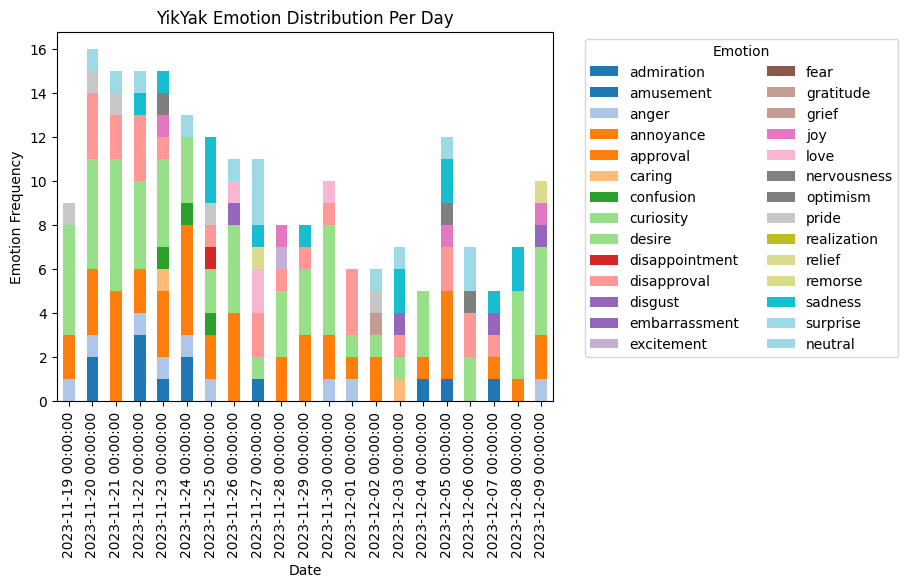

In [103]:
dfs = []

for date, group in grouped_data:
    print('Date: {}'.format(date))

    emotion_totals = {emotion: 0.0 for emotion in LABELS}
    total_emotions = {emotion: 0.0 for emotion in LABELS}

    for index, row in group.iterrows():
        print(row[1])
        results = model.predict(x=[row[1]])
        print('')
        print('{}:'.format(row[1]))
        labels = np.flip(np.argsort(results[0]))

        neutral = False

        for x in range(3):
            label = LABELS[labels[x]]
            if (x == 0):
              if label == 'neutral':
                neutral = True
              else:
                emotion_totals[label] += 1
            if (x == 1 and neutral):
              emotion_totals[label] += 1
            total_emotions[label] += results[0][labels[x]]
            print('{}: {}'.format(label, results[0][labels[x]]))

    top_emotion = max(emotion_totals, key=emotion_totals.get)
    print('Top Emotion: {} ({:.2%})'.format(top_emotion, emotion_totals[top_emotion]))

    df_plot = pd.DataFrame([emotion_totals], index=[date])
    dfs.append(df_plot)

df_combined = pd.concat(dfs)

cmap = get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, len(LABELS))]

ax = df_combined.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Date')
plt.ylabel('Emotion Frequency')
plt.title('YikYak Emotion Distribution Per Day')

# Customize the legend with unique colors
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()


In [104]:
labeled_data = pd.read_csv('/LabeledData - Sheet1.csv')

In [105]:
labeled_data

,Date,Emotion Detected
0,11/20,disappointment
1,11/20,pride
2,11/20,confusion
3,11/20,annoyance
4,11/20,neutral
5,11/20,embarassment
6,11/20,confusion
7,11/20,amusement
8,11/20,sadness
9,11/20,neutral
